In [1]:
# import sys
# sys.path.append('/Users/hamzacostelle/opt/anaconda3/envs/project-env/lib/python3.7/site-packages')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1963k  100 1963k    0     0  1006k      0  0:00:01  0:00:01 --:--:-- 1006k


# Time-Series Forecasting with Beijing PM2.5 Dataset
**Duration**: Year 2010 to 2014

## Attribute Information:

- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3), Particle Matter 2.5 denotes pollution in air.
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

- The concentration of an air pollutant (eg. ozone) is given in micrograms (one-millionth of a gram) per cubic meter air or µg/m3.


- 5 is considered safe by the US Environmental Protection Agency's national ambient air quality standards so long as a person breathes in an average of 12 micrograms per cubic meter of air (μg/m3) or less per day over the duration of a year.

Response Variable: pm2.5<br>
Explanatory Variables: All other attributes

## Basic Exploration and Feature Engineering 

We will take a high-level overview of the dataset and look at the attributes.Cleaning and pre-processing data will take care of issues like 
- Setting up data as Time-series data using datetime parser, creating index as time
- Renaming columns to remove ambiguity
- Addressing null values, incorrect data-types
- Getting data information for attribute columns 
- Getting Statistical information on distribution of data, understand central tendencies, outliers if any

In [22]:
# Look at our dataset first
df = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0)
df.sample(10)

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
19301,2012,3,15,4,46.0,-10,-4.0,1027.0,NW,0.89,0,0
32157,2013,9,1,20,66.0,17,23.0,1013.0,NE,3.13,0,2
3458,2010,5,25,1,24.0,-2,22.0,1009.0,NW,4.92,0,0
6368,2010,9,23,7,NaN,7,11.0,1020.0,NW,16.54,0,0
23289,2012,8,28,8,92.0,22,24.0,1006.0,cv,0.89,0,0
15157,2011,9,24,12,134.0,13,26.0,1014.0,cv,0.89,0,0
19147,2012,3,8,18,17.0,-22,2.0,1028.0,SE,0.89,0,0
32515,2013,9,16,18,50.0,13,23.0,1009.0,SE,16.99,0,0
16174,2011,11,5,21,37.0,6,10.0,1028.0,cv,0.89,0,0


Before further analysis we will convert our data into a time series dataframe

In [23]:
# parse the datetime columns into a single column
from datetime import datetime

def parse_date(x):
    return datetime.strptime(x,'%Y %m %d %H')

df1 = pd.read_csv('PRSA_data_2010.1.1-2014.12.31.csv', index_col=0,date_parser=parse_date,parse_dates=[['year','month','day','hour']]) 
df1.drop(columns='No', axis=1, inplace=True)
# set date as index
df1.index.name = 'time'
df1.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0


Next we will change the column names to remove ambiguity, so we don't have to refer again from the above attribute details.

In [25]:
# Change column names
df2 = df1.copy()
df2.columns = ['pm2.5','dew_pt','temp','pressure', 'wind_dir','wind_spd','cum_snow','cum_rain']
df2.head(30)
# df2.sample(30)

,pm2.5,dew_pt,temp,pressure,wind_dir,wind_spd,cum_snow,cum_rain
time,,,,,,,,
2010-01-01 00:00:00,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,NaN,-20,-12.0,1018.0,NW,12.97,0,0
2010-01-01 05:00:00,NaN,-19,-10.0,1017.0,NW,16.10,0,0
2010-01-01 06:00:00,NaN,-19,-9.0,1017.0,NW,19.23,0,0
2010-01-01 07:00:00,NaN,-19,-9.0,1017.0,NW,21.02,0,0
2010-01-01 08:00:00,NaN,-19,-9.0,1017.0,NW,24.15,0,0


In [26]:
#  check data for nulls
df2.isnull().sum()

pm2.5       2067
dew_pt         0
temp           0
pressure       0
wind_dir       0
wind_spd       0
cum_snow       0
cum_rain       0
dtype: int64

Looking at the dataset, we can see that our 'pollution' column has about 2067 NaN values and we don't have data for day 1 on Jan, 2010.<br>
We can't drop all the null records based on pollution column.Hence we will first remove the rows of records from day 1 from the data 
set and then use forward fill to remove null data completely from that column.

In [27]:
# Fix nulls in 'pm2.5, the pollution column
df2 = df2[24:].fillna(method='ffill')
df2.sample(15)

,pm2.5,dew_pt,temp,pressure,wind_dir,wind_spd,cum_snow,cum_rain
time,,,,,,,,
2014-04-24 15:00:00,136.0,13,25.0,1013.0,SE,10.28,0,0
2010-01-04 12:00:00,29.0,-21,-11.0,1030.0,NW,117.55,0,0
2012-01-04 21:00:00,87.0,-17,-3.0,1032.0,cv,1.79,0,0
2012-05-19 00:00:00,146.0,15,24.0,1006.0,SE,1.79,0,0
2011-02-23 18:00:00,396.0,-3,6.0,1013.0,NW,1.79,0,0
2013-08-09 02:00:00,26.0,18,22.0,1000.0,NW,15.20,0,0
2012-02-03 09:00:00,52.0,-23,-8.0,1026.0,NW,27.27,0,0
2012-06-08 03:00:00,99.0,15,21.0,1001.0,SE,8.94,0,1
2014-07-25 12:00:00,31.0,17,32.0,1005.0,cv,1.79,0,0


Our dataset now looks good. We have taken a sample instead of head to randomly check our data. Let's look at the data information. 
We can get the null data details and data types.

In [28]:
df2.info()
df2.shape

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pm2.5     43800 non-null  float64
 1   dew_pt    43800 non-null  int64  
 2   temp      43800 non-null  float64
 3   pressure  43800 non-null  float64
 4   wind_dir  43800 non-null  object 
 5   wind_spd  43800 non-null  float64
 6   cum_snow  43800 non-null  int64  
 7   cum_rain  43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


(43800, 8)

The above info shows that we have no null data in our columns. The data types of most of our numerical columns are integers or float.The categorical column 'win_dir' is of type object so we are good.<br>
The shape tells us that we have 43800 records and 8 attribute columns

## Exploratory Data Analysis and Visualization of data

We will begin our EDA with simple distribution statistics that include mean, standard deviation, quartiles etc.

In [29]:
df2.describe()

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain
count,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000,43800.000000
mean,97.784018,1.828516,12.459041,1016.447306,23.894307,0.052763,0.195023
std,91.398542,14.429326,12.193384,10.271411,50.022729,0.760582,1.416247
min,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,136.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


**Observation**:
- Looking at the max values for columns pm2.5, wind_spd, cum_snow and cum_rain are quite far from the 75% quartile indicating outliers.
- We have some negative values for dew_pt and temp

### Visualization of data distribution

Let's plot the categorical column and numerical columns to understand the distribution of data.<br>
We will use a box plot to plot our categorical column wind_dir

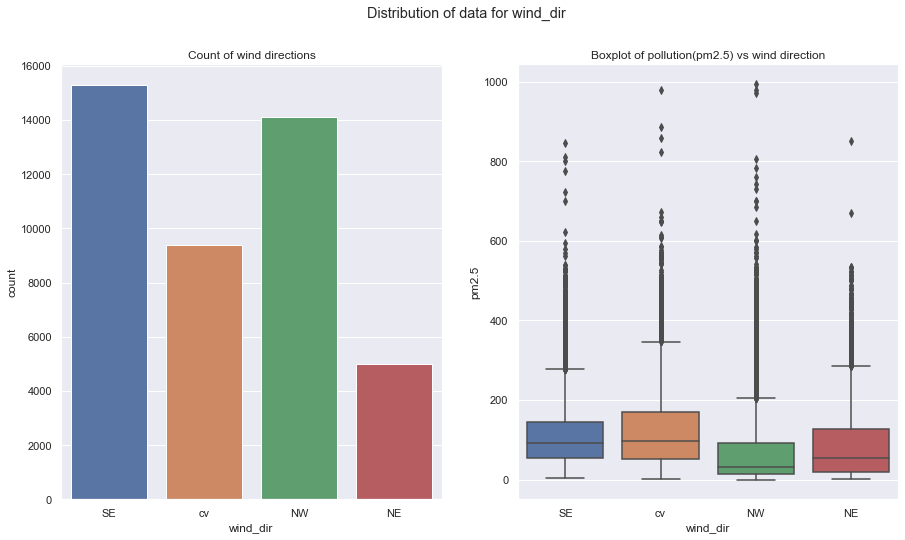

In [30]:
# Create a seaborn count plot  for the categorical column wind_dir

fig, ax = plt.subplots(1,2, figsize=(15,8));
fig.suptitle('Distribution of data for wind_dir');
sns.countplot(data=df2, x='wind_dir', ax=ax[0]);
ax[0].set_title('Count of wind directions');
sns.boxplot(data=df2,x='wind_dir', y='pm2.5', ax=ax[1]);
ax[1].set_title('Boxplot of pollution(pm2.5) vs wind direction');

**Observation**: Categorical column

- The count plot of wind direction shows the highest count for SE direction followed by NW direction
- The box plot shows overlapping boxes, so the groups are not very different
- However the median lines of both NW and NE lie out side of boxes for both SE and CV indicating a difference.
- All the groups have outliers on the max side.
- As a result data for all the wind directions groups are skewed to right.

Next we have created a numeric dataframe, df2_numeric out of the df2, to analyse the data distribution in numeric column

In [31]:
# Created numeric dataframe
df2_numeric = df2.drop(['wind_dir'], axis=1)
df2_numeric.sample(15)

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain
time,,,,,,,
2013-11-29 02:00:00,38.0,-14,-2.0,1023.0,0.89,0,0
2010-10-28 17:00:00,59.0,0,16.0,1026.0,7.15,0,0
2011-07-16 01:00:00,78.0,19,25.0,1006.0,39.35,0,0
2010-12-09 04:00:00,158.0,-8,-2.0,1014.0,5.81,0,0
2011-01-14 03:00:00,18.0,-18,-4.0,1029.0,29.95,0,0
2014-06-16 15:00:00,132.0,21,29.0,1000.0,3.13,0,0
2013-01-20 08:00:00,87.0,-5,-4.0,1032.0,0.89,4,0
2010-05-24 00:00:00,100.0,11,19.0,1000.0,0.89,0,0
2014-03-28 21:00:00,183.0,7,15.0,1010.0,23.24,0,0


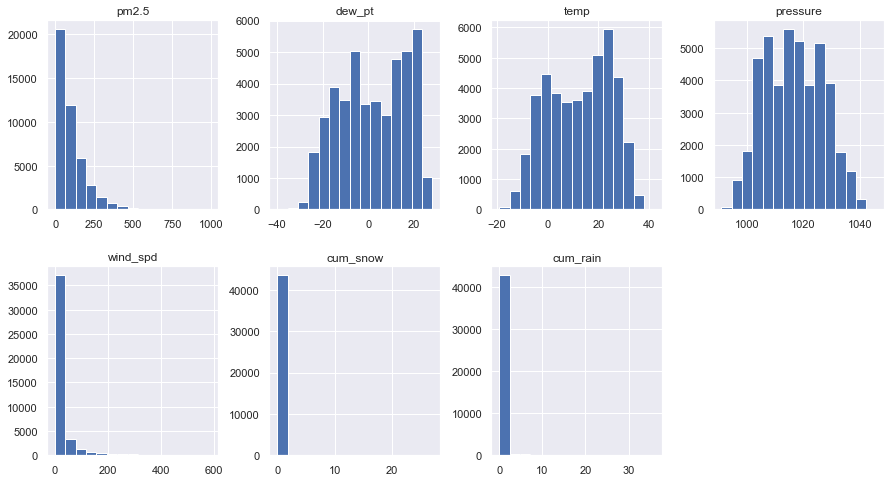

In [32]:
df2_numeric.hist(bins=15,figsize=(15,8),layout=(2,4));

**Observation**: Numeric Columns

- The pm2.5 and wind_spd data is skewed to right.
- Both columns dew_pt and temp are bimodal and have negative numbers.
- The data for pressure is multimodal.
- For cum_snow and cum_rain except for few outlier values, most of the data has 0 values

### Resampling
*Resampling* generates a unique sampling distribution on the basis of the actual data. We can apply various frequency to resample our time series data.
<br> We will resample the pm2.5 column (response variable) based on months and plot the data for visualization

In [33]:
# Resampling the time series data based on months 'M'
# Find mean of particle matter 2.5 of each month for 
# a duration of 12 months for years 2010 to 
ts_mean_month = df2['pm2.5'].resample('M').mean()
ts_mean_month.head(15)

time
2010-01-31     84.073611
2010-02-28     98.547619
2010-03-31     99.971774
2010-04-30     79.865278
2010-05-31     86.892473
2010-06-30    110.325000
2010-07-31    123.647849
2010-08-31    101.842742
2010-09-30     85.969444
2010-10-31    118.727151
2010-11-30    130.580556
2010-12-31     97.333333
2011-01-31     42.353495
2011-02-28    150.321429
2011-03-31     67.802419
Freq: M, Name: pm2.5, dtype: float64

**Observation**:
Resampling and getting the monthly means do not address the outliers in the pm2.5 column.


In [34]:
#Creating dummy variables for the wind_dir: Combined wind direction
df2 = df2.join(pd.get_dummies(df2['wind_dir'])) # one-hot encoding
del df2['wind_dir']
df2.head()

,pm2.5,dew_pt,temp,pressure,wind_spd,cum_snow,cum_rain,NE,NW,SE,cv
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,1.79,0,0,0,0,1,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2.68,0,0,0,0,1,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,3.57,0,0,0,0,1,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,5.36,1,0,0,0,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,6.25,2,0,0,0,1,0


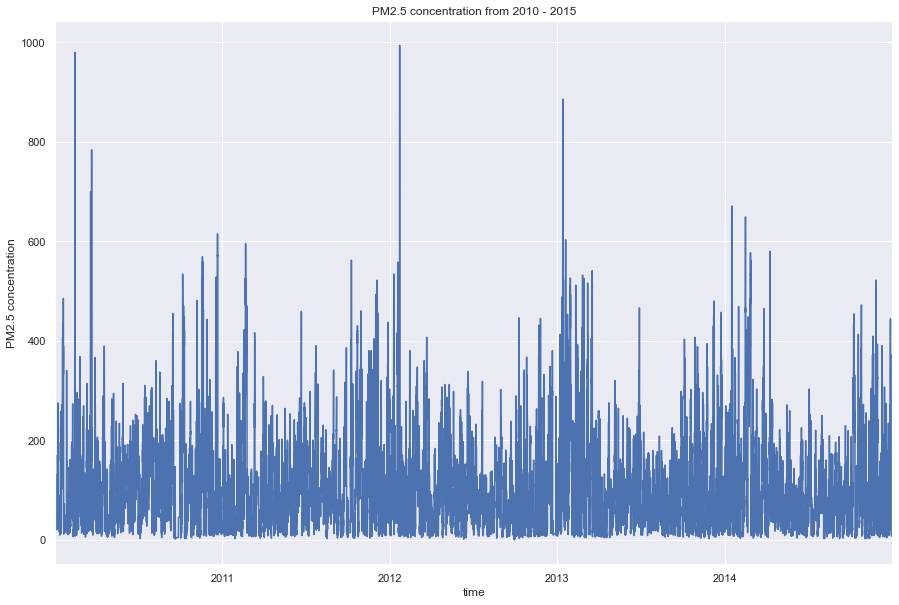

In [35]:
plt.subplots(figsize=(15,10))
plt.xlabel('Time')
plt.ylabel('PM2.5 concentration')
plt.title('PM2.5 concentration from 2010 - 2015')
df2['pm2.5'].plot()
plt.show()

In [36]:
scatter_y = df2['pm2.5'].resample('D').mean()
scatter_x = df2['pm2.5'].resample('D').mean().index

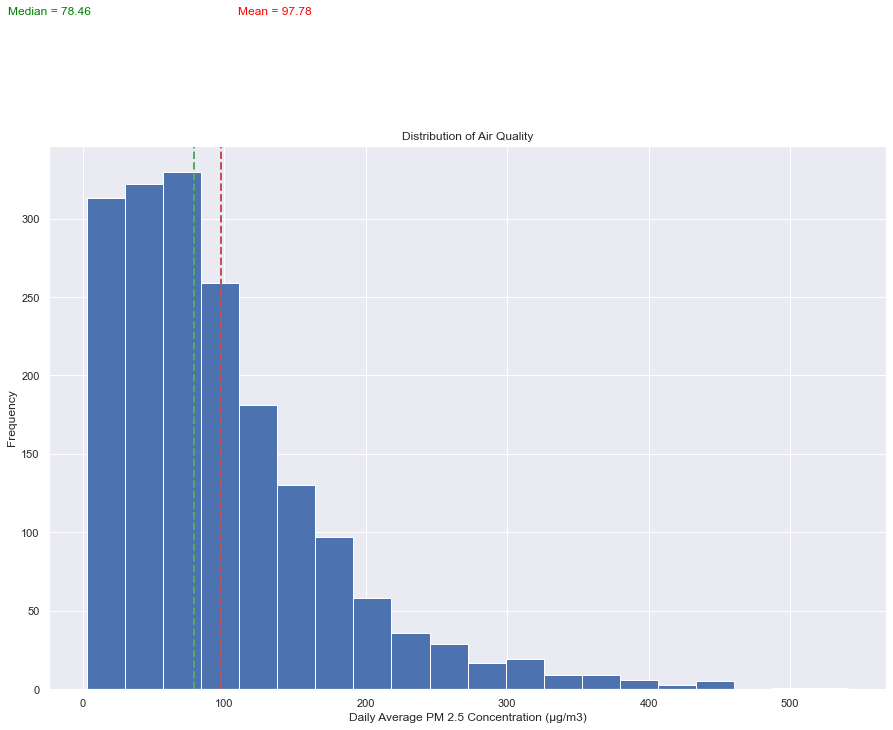

In [37]:
plt.figure(figsize=(15,10))
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)
plt.show()

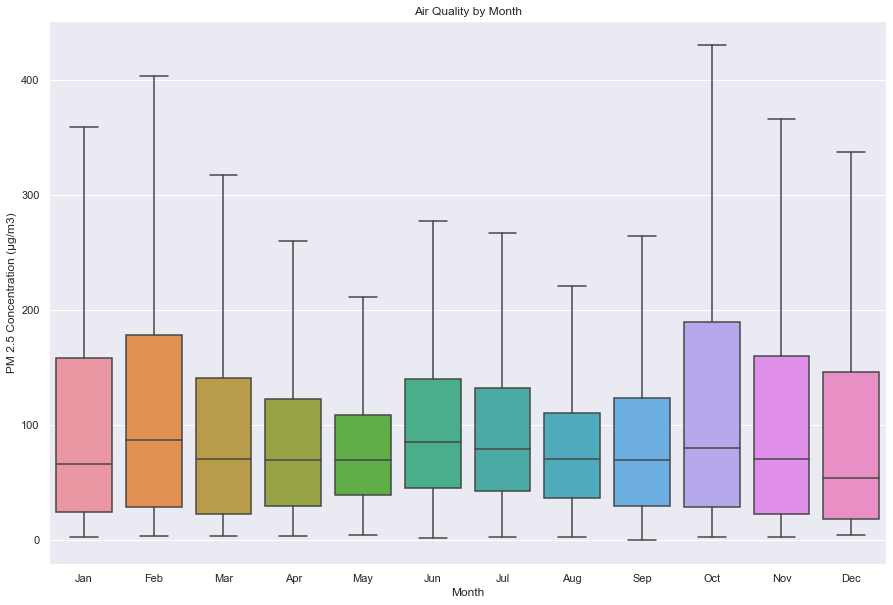

In [38]:
import calendar
plt.figure(figsize=(15,10))
sns.boxplot(x="month", y="pm2.5", data=df, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])
plt.show()

In [41]:
values=df2.values

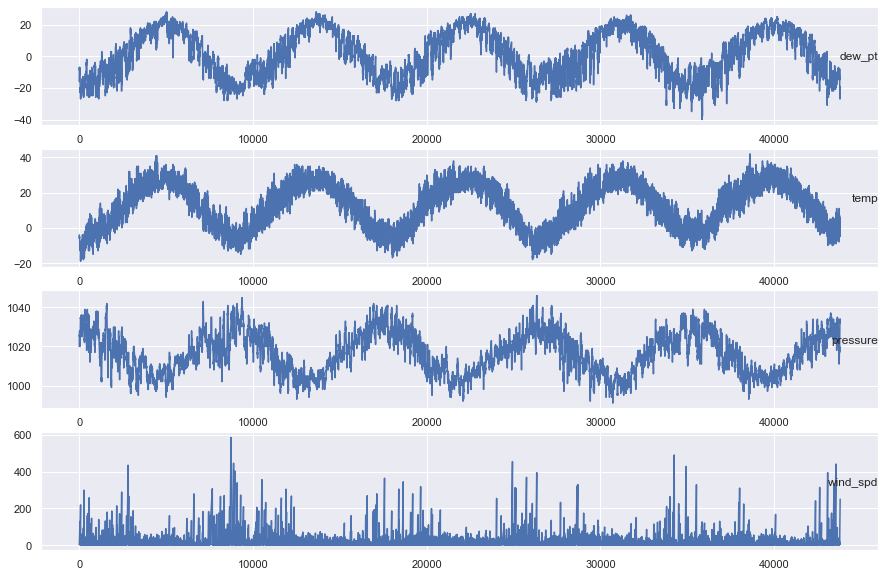

In [42]:
# specify columns to plot
groups = [1,2,3,4]
i = 1
# plotting each column
plt.figure(figsize=(15,10))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df2.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [44]:
df_numeric = df2.loc[:,['wind_spd','dew_pt','temp','pressure', 'cum_snow','cum_rain']]
df_numeric

,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,
2010-01-02 00:00:00,1.79,-16,-4.0,1020.0,0,0
2010-01-02 01:00:00,2.68,-15,-4.0,1020.0,0,0
2010-01-02 02:00:00,3.57,-11,-5.0,1021.0,0,0
2010-01-02 03:00:00,5.36,-7,-5.0,1022.0,1,0
2010-01-02 04:00:00,6.25,-7,-5.0,1022.0,2,0
...,...,...,...,...,...,...
2014-12-31 19:00:00,231.97,-23,-2.0,1034.0,0,0
2014-12-31 20:00:00,237.78,-22,-3.0,1034.0,0,0
2014-12-31 21:00:00,242.70,-22,-3.0,1034.0,0,0


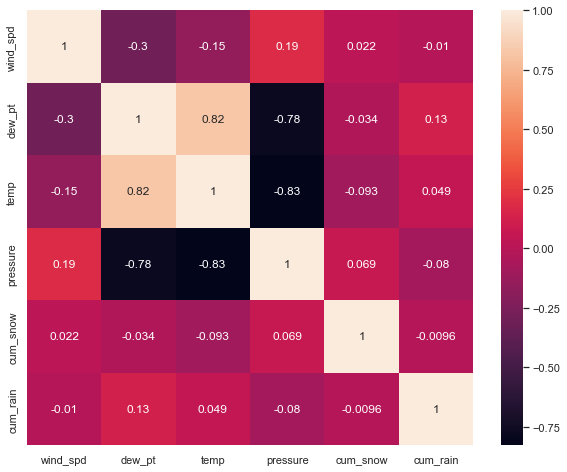

In [45]:
corr = df_numeric.corr()
plt.subplots(figsize=(10,8))
sns.heatmap(corr, annot=True)
plt.show()

In [46]:
scaler = StandardScaler()
df3 = scaler.fit_transform(df_numeric)

In [47]:
df4 = pd.DataFrame(data=df3, index=df_numeric.index, columns=df_numeric.columns)
df4

,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,
2010-01-02 00:00:00,-0.441890,-1.235589,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 01:00:00,-0.424098,-1.166285,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 02:00:00,-0.406306,-0.889069,-1.431862,0.443244,-0.069372,-0.137706
2010-01-02 03:00:00,-0.370522,-0.611852,-1.431862,0.540603,1.245425,-0.137706
2010-01-02 04:00:00,-0.352730,-0.611852,-1.431862,0.540603,2.560223,-0.137706
...,...,...,...,...,...,...
2014-12-31 19:00:00,4.159670,-1.720718,-1.185824,1.708908,-0.069372,-0.137706
2014-12-31 20:00:00,4.275819,-1.651414,-1.267837,1.708908,-0.069372,-0.137706
2014-12-31 21:00:00,4.374175,-1.651414,-1.267837,1.708908,-0.069372,-0.137706


In [48]:
df5 = df2.drop(['wind_spd','dew_pt','temp','pressure', 'cum_snow','cum_rain'], axis = 1)
final_df = pd.concat([df5,df4], axis = 1)
final_df

,pm2.5,NE,NW,SE,cv,wind_spd,dew_pt,temp,pressure,cum_snow,cum_rain
time,,,,,,,,,,,
2010-01-02 00:00:00,129.0,0,0,1,0,-0.441890,-1.235589,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 01:00:00,148.0,0,0,1,0,-0.424098,-1.166285,-1.349849,0.345886,-0.069372,-0.137706
2010-01-02 02:00:00,159.0,0,0,1,0,-0.406306,-0.889069,-1.431862,0.443244,-0.069372,-0.137706
2010-01-02 03:00:00,181.0,0,0,1,0,-0.370522,-0.611852,-1.431862,0.540603,1.245425,-0.137706
2010-01-02 04:00:00,138.0,0,0,1,0,-0.352730,-0.611852,-1.431862,0.540603,2.560223,-0.137706
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,0,1,0,0,4.159670,-1.720718,-1.185824,1.708908,-0.069372,-0.137706
2014-12-31 20:00:00,10.0,0,1,0,0,4.275819,-1.651414,-1.267837,1.708908,-0.069372,-0.137706
2014-12-31 21:00:00,10.0,0,1,0,0,4.374175,-1.651414,-1.267837,1.708908,-0.069372,-0.137706


In [49]:
#Train-test Split 
features = final_df.drop("pm2.5",axis=1)
X = features
y = final_df['pm2.5']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 0)

In [50]:
l_reg = LinearRegression()
tree_reg = DecisionTreeRegressor()
rnd_reg = RandomForestRegressor(n_estimators=30, random_state=0)
sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, random_state=0)
lasso_reg = Lasso(alpha=0.1)
elastic_reg = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=0)
ridge_reg = Ridge(alpha=.5, solver="cholesky", random_state=0)
bag_reg = BaggingRegressor(
    DecisionTreeRegressor(random_state=0), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=0)

In [51]:
for reg in (l_reg,tree_reg,rnd_reg,sgd_reg,lasso_reg,elastic_reg,ridge_reg, bag_reg):
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print(reg.__class__.__name__," r2_score: ",  r2_score(y_test, y_pred))
    print(reg.__class__.__name__,' MSE: ',  mean_squared_error(y_test, y_pred))
    print(reg.__class__.__name__," RMSE: " , np.sqrt(mean_squared_error(y_test, y_pred)))
    print('\n')

LinearRegression  r2_score:  0.24600571390572867
LinearRegression  MSE:  6464.524367021429
LinearRegression  RMSE:  80.40226593213296


DecisionTreeRegressor  r2_score:  -0.10001623137833437
DecisionTreeRegressor  MSE:  9431.214351371398
DecisionTreeRegressor  RMSE:  97.11443945866854


RandomForestRegressor  r2_score:  0.40141041151332113
RandomForestRegressor  MSE:  5132.130378152034
RandomForestRegressor  RMSE:  71.63888872778551


SGDRegressor  r2_score:  0.24570940502028826
SGDRegressor  MSE:  6467.064831910117
SGDRegressor  RMSE:  80.41806284604297


Lasso  r2_score:  0.246034188152928
Lasso  MSE:  6464.280237233912
Lasso  RMSE:  80.4007477405149


ElasticNet  r2_score:  0.23456263527430365
ElasticNet  MSE:  6562.633944256792
ElasticNet  RMSE:  81.01008544778108


Ridge  r2_score:  0.24605749932276222
Ridge  MSE:  6464.080374147154
Ridge  RMSE:  80.39950481282303


BaggingRegressor  r2_score:  0.3174543414346661
BaggingRegressor  MSE:  5851.944932177667
BaggingRegressor  RMSE:  7

Random Forest Regressor was by far the best predictor and was still less than 50/50 in its prediction. Overall very poor performance from all of the models. 